In [124]:
from theFuncs import *

# DATA

In [125]:
# load_DTB3_SPY().to_csv('./data/spy_dtb3.csv')

In [126]:
sp100 = os.listdir(os.getcwd()+'/data/stock_dfs')
sp100_tickers = []
for csvfile in sp100:
    sp100_tickers.append(csvfile[:-4])

# sp100_tickers

In [127]:
ticker_data = get_ticker_data_multisource(
    sp100_tickers, 
    start="2006-01-02", 
    end="2011-01-01"
)

In [128]:
# nyse_tickers_cap = pd.read_csv("data/tickers_nyse.csv", index_col=0).MarketCap.dropna().apply(
#     lambda x: float(x[1: -1]) * 1e6 if x[-1] == "M" else float(x[1: -1]) * 1e6
# ).sort_values(ascending=False)[:200]

# nyse_tickers = nyse_tickers_cap.index

In [129]:
# nyse_ticker_weights = nyse_tickers_cap / nyse_tickers_cap.sum()
# nyse_ticker_weights.head()

In [130]:
# ticker_data = get_ticker_data_multisource(nyse_tickers)

In [132]:
tickers = sp100_tickers

model = RollingOLS.from_formula(
        "(ret - DTB3) ~ (spy_ret - DTB3)", 
        data = ticker_data.loc[tickers[0]], 
        window = 66
    ).fit(params_only=True)
df = model.params
df.columns = ["alpha", "Beta"]
df['ticker'] = tickers[0]
df.set_index('ticker', inplace=True, append=True)
df = df.reorder_levels(['ticker', 'date']).sort_index()


for ticker in tickers[1:]:
    try:
        model = RollingOLS.from_formula(
            "(ret - DTB3) ~ (spy_ret - DTB3)", 
            data = ticker_data.loc[ticker], 
            window = 66
        ).fit(params_only=True)

        temp = model.params
        temp.columns = ["alpha", "Beta"]
        temp['ticker'] = ticker
        temp.set_index('ticker', inplace=True, append=True)
        temp = temp.reorder_levels(['ticker', 'date']).sort_index()
        df = pd.concat(
            [ 
                df, 
                temp
            ]
        )
    except:
        continue

ticker_data = ticker_data.join(df)

ticker_data.head()

high       low      open     close        volume  \
ticker date                                                               
AAPL   2006-01-04  2.713571  2.660714  2.683214  2.677500  6.196036e+08   
       2006-01-05  2.675000  2.633929  2.672500  2.656429  4.494224e+08   
       2006-01-06  2.739286  2.662500  2.687500  2.725000  7.044576e+08   
       2006-01-09  2.757143  2.705000  2.740357  2.716071  6.750408e+08   
       2006-01-10  2.924643  2.708214  2.723214  2.887857  2.279869e+09   

                        ret  spy_close    DTB3   spy_ret  alpha  Beta  
ticker date                                                            
AAPL   2006-01-04  0.002943  93.228043  0.0409  0.004736    NaN   NaN  
       2006-01-05 -0.007870  93.286591  0.0410  0.000628    NaN   NaN  
       2006-01-06  0.025813  94.062912  0.0412  0.008322    NaN   NaN  
       2006-01-09 -0.003277  94.304581  0.0414  0.002569    NaN   NaN  
       2006-01-10  0.063248  94.399765  0.0419  0.001009    NaN   NaN

In [133]:
market_caps = pd.DataFrame(
    ticker_data.close * ticker_data.volume,
    columns=["MarketCap"]
)
market_caps.head()

MarketCap
ticker date                    
AAPL   2006-01-04  1.658989e+09
       2006-01-05  1.193859e+09
       2006-01-06  1.919647e+09
       2006-01-09  1.833459e+09
       2006-01-10  6.583936e+09

In [134]:
market_caps = market_caps.ewm(66).mean()

In [135]:
market_caps.head()

MarketCap
ticker date                    
AAPL   2006-01-04  1.658989e+09
       2006-01-05  1.424675e+09
       2006-01-06  1.592153e+09
       2006-01-09  1.653847e+09
       2006-01-10  2.669741e+09

In [136]:
ticker_data_wide = ticker_data.reset_index(level=['ticker', 'date'])
ticker_data_wide = ticker_data_wide[['ticker', 'date', 'ret']].pivot(
    index='date', 
    columns='ticker', 
    values='ret'
)
ticker_data_wide.head()

ticker,AAPL,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AVGO,AXP,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2006-01-04,0.002943,0.001517,0.005461,-0.002596,0.001436,-0.004729,0.030769,-0.006936,NaN,-0.011982,...,0.002430,-0.000873,0.001324,0.003633,NaN,0.029296,-0.031064,-0.011599,0.001947,0.001710
2006-01-05,-0.007870,0.012876,0.007468,-0.009110,0.001291,-0.014504,-0.003198,0.008466,NaN,0.010587,...,-0.003070,-0.011488,0.000397,0.004936,NaN,0.011513,-0.009095,-0.001110,-0.013601,-0.004951
2006-01-06,0.025813,0.019192,0.049528,0.024429,0.004297,-0.009135,0.015330,0.004617,NaN,0.003429,...,0.019614,-0.007327,-0.005946,0.007859,NaN,-0.008852,-0.004819,0.005874,0.004159,0.019732
2006-01-09,-0.003277,0.037173,-0.002889,-0.015897,-0.004707,0.011268,0.021770,-0.016503,NaN,0.024867,...,-0.023847,0.013871,0.012229,0.000325,NaN,0.004147,0.012451,-0.000158,-0.003705,-0.000505
2006-01-10,0.063248,-0.009668,-0.021571,0.005993,0.008885,-0.012661,-0.001375,-0.030374,NaN,-0.002964,...,0.019707,-0.002134,-0.005384,-0.004547,NaN,0.004130,-0.014348,-0.000789,0.003282,0.007744


In [137]:
rolling_correlations = ticker_data_wide.rolling(66).corr().fillna(0)
rolling_correlations.head()

ticker             AAPL  ABT  ACN  ADBE  AIG  AMGN  AMT  AMZN  AVGO  AXP  ...  \
date       ticker                                                         ...   
2006-01-04 AAPL     0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0  ...   
           ABT      0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0  ...   
           ACN      0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0  ...   
           ADBE     0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0  ...   
           AIG      0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0  ...   

ticker             UNH  UNP  UPS  USB    V   VZ  WBA  WFC  WMT  XOM  
date       ticker                                                    
2006-01-04 AAPL    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABT     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ACN     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ADBE    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           AIG     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 96 columns]

In [138]:
filter_correlations = rolling_correlations.groupby(["date"]).sum().sum(axis=1)
filter_correlations_dates = filter_correlations[filter_correlations > 0].index
rolling_correlations = rolling_correlations.loc[filter_correlations_dates]

In [139]:
rolling_covariances = ticker_data_wide.rolling(66).cov().fillna(0)
rolling_covariances.head()

ticker             AAPL  ABT  ACN  ADBE  AIG  AMGN  AMT  AMZN  AVGO  AXP  ...  \
date       ticker                                                         ...   
2006-01-04 AAPL     0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0  ...   
           ABT      0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0  ...   
           ACN      0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0  ...   
           ADBE     0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0  ...   
           AIG      0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0  ...   

ticker             UNH  UNP  UPS  USB    V   VZ  WBA  WFC  WMT  XOM  
date       ticker                                                    
2006-01-04 AAPL    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABT     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ACN     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ADBE    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           AIG     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 96 columns]

In [140]:
filter_covariances = rolling_covariances.groupby(["date"]).sum().sum(axis=1)
filter_covariances_dates = filter_covariances[filter_covariances > 0].index
rolling_covariances = rolling_covariances.loc[filter_covariances_dates]

In [141]:
rolling_covariances.loc[('2019-06-24', 'AAPL'), 'AAPL']

Series([], Name: AAPL, dtype: float64)

In [142]:
ticker_data.to_csv("data/test_run/ticker_data.csv")
ticker_data_wide.to_csv("data/test_run/ticker_data_wide.csv")
rolling_correlations.to_csv("data/test_run/rolling_correlations.csv")
rolling_covariances.to_csv("data/test_run/rolling_covariances.csv")

In [143]:
pd.read_csv("data/test_run/ticker_data.csv")

,ticker,date,high,low,open,close,volume,ret,spy_close,DTB3,spy_ret,alpha,Beta
0,AAPL,2006-01-04,2.713571,2.660714,2.683214,2.677500,6.196036e+08,0.002943,93.228043,0.0409,0.004736,NaN,NaN
1,AAPL,2006-01-05,2.675000,2.633929,2.672500,2.656429,4.494224e+08,-0.007870,93.286591,0.0410,0.000628,NaN,NaN
2,AAPL,2006-01-06,2.739286,2.662500,2.687500,2.725000,7.044576e+08,0.025813,94.062912,0.0412,0.008322,NaN,NaN
3,AAPL,2006-01-09,2.757143,2.705000,2.740357,2.716071,6.750408e+08,-0.003277,94.304581,0.0414,0.002569,NaN,NaN
4,AAPL,2006-01-10,2.924643,2.708214,2.723214,2.887857,2.279869e+09,0.063248,94.399765,0.0419,0.001009,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114962,XOM,2010-12-27,73.300003,72.809998,72.809998,73.010002,9.757200e+06,-0.002596,101.974419,0.0017,0.000398,0.001136,0.913035
114963,XOM,2010-12-28,73.559998,72.959999,73.199997,73.419998,1.442340e+07,0.005616,102.120506,0.0015,0.001433,0.001157,0.916395
114964,XOM,2010-12-29,73.690002,73.339996,73.410004,73.370003,1.179770e+07,-0.000681,102.193542,0.0013,0.000715,0.001186,0.974802
114965,XOM,2010-12-30,73.510002,73.050003,73.290001,73.360001,1.079040e+07,-0.000136,102.031265,0.0012,-0.001588,0.001139,0.979950


# CLUSTERING

In [144]:
date = get_closest_trading_day("2020-03-23", ticker_data)
K = 10

In [145]:
x, y, z = clustering_model(rolling_correlations, date, K, GRB.MINIMIZE)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9313 rows, 9312 columns and 27744 nonzeros
Model fingerprint: 0x3eee428c
Variable types: 0 continuous, 9312 integer (9312 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 27.3632816
Presolve time: 0.05s
Presolved: 9313 rows, 9312 columns, 27744 nonzeros
Variable types: 0 continuous, 9312 integer (9312 binary)

Root relaxation: objective -9.107993e+00, 173 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      -9.1079934   -9.10799  0.00%     -    0s

Explored 0 nodes (173 simplex iterations) in 0.09 seconds
Thread count was 8 (of 

# INDEX BY CLUSTER WEIGHTS

In [146]:
z_market_cap = market_caps.loc[
    market_caps.index.get_level_values(1) == date
].join(z)
z_market_cap.reset_index(drop=True, level=1, inplace=True)

In [147]:
center_weights = z_market_cap[(z_market_cap.in_center == 1) & (z_market_cap.is_center == 1)].groupby("center").MarketCap.sum() / z_market_cap[(z_market_cap.in_center == 1) & (z_market_cap.is_center == 1)].MarketCap.sum()

In [148]:
portfolio_returns = get_portfolio_returns(
    center_weights, date, ticker_data_wide
)
spy_returns = get_spy_returns(date)

portfolio_returns, spy_returns

(0.9907266939983514, 1.0592266373907337)

In [149]:
portfolio_returns - spy_returns

-0.0684999433923823

In [150]:
get_portfolio_beta(center_weights, date, ticker_data)

0.2529237148195824

In [151]:
# master_func("2020-03-23", K, rolling_correlations, market_caps, ticker_data, ticker_data_wide, rolling_covariances, 0.5, 1.5, 1e-3)

# INDEX BY MIN VAR

In [152]:
mean_var_step, obj = mean_variance_model(
    market_caps, 
    ticker_data, 
    date, 
    rolling_covariances, 
    center_weights,
    0.5, 
    1.5, 
    1e-3
)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 90 rows, 96 columns and 467 nonzeros
Model fingerprint: 0x9616cf63
Model has 4560 quadratic objective terms
Coefficient statistics:
  Matrix range     [4e-05, 2e+00]
  Objective range  [2e-05, 2e-04]
  QObjective range [4e-07, 4e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 87 rows and 87 columns
Presolve time: 0.01s
Presolved: 3 rows, 10 columns, 28 nonzeros
Presolved model has 45 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 8
 AA' NZ     : 5.500e+01
 Factor NZ  : 6.600e+01
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.82579196e+05 -4.82623784e+05  6.25e+03 2.36e-03  4.03e+05     0s
   1   4.7

In [153]:
obj

0.008119018911097137

In [154]:
mean_var_step_return = get_portfolio_returns(mean_var_step.weights, date, ticker_data_wide)
mean_var_step_return, spy_returns

(0.9975114471307491, 1.0592266373907337)

In [155]:
mean_var_step_return - spy_returns

-0.06171519025998462

In [156]:
get_portfolio_beta(mean_var_step.weights, date, ticker_data)

0.5305594404956182

# Method Comparison

In [157]:
pd.concat(
    [
        mean_var_step[mean_var_step.weights > 0], 
        center_weights
    ], 
    axis=1
)

,weights,MarketCap
center,,
ADBE,1.278917e-01,0.007755
AVGO,2.194985e-01,0.023935
CL,7.212258e-02,0.022808
COF,1.358274e-01,0.065229
CRM,3.242788e-02,0.019050
EXC,2.408328e-08,0.053056
GM,3.279860e-01,0.214285
NFLX,3.090718e-02,0.447607
PEP,1.941404e-08,0.005230


# Master Func

In [158]:
start_date = get_closest_trading_day("2000-01-01", rolling_correlations)
end_date = max(ticker_data.index.get_level_values("date"))

master_cluster_index = {}
master_cluster_performance = {}
master_mean_var_index = {}
master_mean_var_performance = {}

while start_date < end_date:
    print(start_date)
    master_func(
        start_date, 
        10, 
        rolling_correlations, 
        market_caps, 
        ticker_data, 
        ticker_data_wide, 
        rolling_covariances,
        0, 
        2, 
        1e-3, 
        master_cluster_index,
        master_cluster_performance,
        master_mean_var_index,
        master_mean_var_performance, 
        # GRB.MINIMIZE
        )

    start_date += relativedelta(months=3)

2006-04-07 00:00:00
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9313 rows, 9312 columns and 27744 nonzeros
Model fingerprint: 0x535c7abc
Variable types: 0 continuous, 9312 integer (9312 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 16.9362368
Presolve time: 0.05s
Presolved: 9313 rows, 9312 columns, 27744 nonzeros
Variable types: 0 continuous, 9312 integer (9312 binary)

Root relaxation: objective 4.778560e+01, 881 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   47.78560    0  166   16.93624   47.78560   182%     -    0s
H    0     0                      46.5073689   47.78560  2.75% 

KeyError: (Timestamp('2006-10-07 00:00:00'), 'AAPL')

In [159]:
rolling_correlations.loc['2006-10-07']

,ticker,AAPL,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AVGO,AXP,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
date,ticker,,,,,,,,,,,,,,,,,,,,,


In [160]:
method1_index = pd.DataFrame.from_dict(master_cluster_index, orient="index")
method1_index

weight
2006-04-07 CAT   0.168525
           CL    0.018243
           CVX   0.041872
           GE    0.063790
           GOOG  0.168864
           KO    0.134609
           LOW   0.085634
           QCOM  0.164235
           SO    0.045647
           USB   0.108580
2006-07-07 BIIB  0.146803
           CVX   0.060903
           GOOG  0.161553
           GS    0.127959
           JPM   0.152567
           KO    0.100533
           LIN   0.104185
           RTX   0.028996
           SO    0.019139
           UPS   0.097363

<AxesSubplot:>

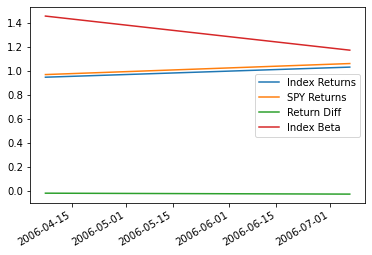

In [161]:
method1_performance = pd.DataFrame.from_dict(master_cluster_performance, orient="index")
method1_performance.plot()

In [162]:
method2_index = pd.DataFrame.from_dict(master_mean_var_index, orient="index")
method2_index

""


In [163]:
method2_performance = pd.DataFrame.from_dict(master_mean_var_performance, orient="index")
method2_performance.plot()

TypeError: no numeric data to plot

In [164]:
comp_index = method1_index.join(
    method2_index, 
    lsuffix=" method 1", 
    rsuffix=" method 2"
)
comp_index

ValueError: cannot join with no overlapping index names

In [ ]:
comp_performance = method1_performance.join(
    method2_performance, 
    lsuffix=" Method 1", 
    rsuffix=" Method 2"
)
comp_performance

,Index Returns Method 1,SPY Returns Method 1,Return Diff Method 1,Index Beta Method 1,Index Returns Method 2,SPY Returns Method 2,Return Diff Method 2,Index Beta Method 2,Active Risk
2019-06-24,1.020338,1.011008,0.009330,1.387511,1.030859,1.011008,0.019851,1.089584,0.003935
2019-09-24,1.110454,1.085771,0.024683,1.204420,1.076816,1.085771,-0.008955,0.900958,0.005170
2019-12-24,0.803940,0.761409,0.042531,1.224780,0.823723,0.761409,0.062314,1.115784,0.004938
2020-03-24,1.393419,1.369940,0.023479,1.171432,1.364166,1.369940,-0.005775,1.085355,0.003894
2020-06-24,1.091946,1.040843,0.051104,1.032549,1.122314,1.040843,0.081471,1.020728,0.004085
2020-09-24,1.116944,1.122045,-0.005100,1.460659,1.116078,1.122045,-0.005966,1.348967,0.008601
2020-12-24,1.057539,1.057728,-0.000190,1.064691,1.035786,1.057728,-0.021943,0.954674,0.009869
2021-03-24,1.175779,1.094970,0.080809,1.156046,1.118403,1.094970,0.023434,0.967190,0.010686
2021-06-24,0.996152,1.053791,-0.057639,1.274201,0.965651,1.053791,-0.088140,1.028863,0.005457
2021-09-24,1.023128,1.061703,-0.038575,1.128761,1.034142,1.061703,-0.027561,0.999401,0.003545


In [ ]:
comp_performance[
    ["Return Diff Method 1", "Return Diff Method 2"]
].add(1).cumprod().fillna(method="ffill")

,Return Diff Method 1,Return Diff Method 2
2019-06-24,1.009330,1.019851
2019-09-24,1.034243,1.010719
2019-12-24,1.078230,1.073701
2020-03-24,1.103545,1.067500
2020-06-24,1.159940,1.154471
2020-09-24,1.154025,1.147582
2020-12-24,1.153806,1.122401
2021-03-24,1.247044,1.148703
2021-06-24,1.175165,1.047456
2021-09-24,1.129833,1.018588


<AxesSubplot:>

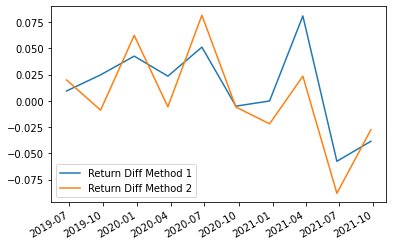

In [ ]:
comp_performance.plot(y=["Return Diff Method 1", "Return Diff Method 2"])

<AxesSubplot:>

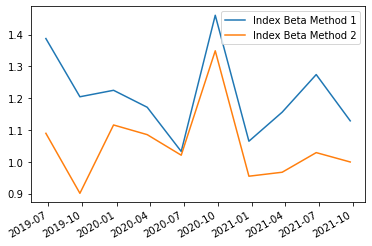

In [ ]:
comp_performance.plot(y=["Index Beta Method 1", "Index Beta Method 2"])